### Nick's parameters

In [6]:
import scqubits as scq
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import scipy.optimize as opt
from qutip.qip.operations import cnot

k = 120
trunc = 6
Fl1 = scq.Fluxonium(EJ=3.95, EC=1.4, EL=0.90, flux=0.5, cutoff=k, truncated_dim=trunc)
Tr = scq.Transmon(EJ=18, EC=0.25, ng=0, ncut=k, truncated_dim=trunc)

J1T = 0.022

full_system = scq.HilbertSpace([Fl1, Tr])
full_system.add_interaction(g=J1T, op1=(Fl1.n_operator(), Fl1), op2=(Tr.n_operator(), Tr))
full_system.generate_bare_esys()
full_system.generate_lookup()

H_full = 2 * np.pi * full_system.hamiltonian()
evals, ekets = H_full.eigenstates()

n_Fl1_full = scq.identity_wrap(Fl1.n_operator(), Fl1, [Fl1, Tr])
n_Tr_full = scq.identity_wrap(Tr.n_operator(), Tr, [Fl1, Tr])

# a_Fl1_full = scq.identity_wrap(qt.destroy(trunc), Fl1, [Fl1, Tr])
# a_Tr_full = scq.identity_wrap(qt.destroy(trunc), Tr, [Fl1, Tr])

# adag_Fl1_full = scq.identity_wrap(qt.create(trunc), Fl1, [Fl1, Tr])
# adag_Tr_full = scq.identity_wrap(qt.create(trunc), Tr, [Fl1, Tr])


total_truncation = 36
def truncate(operator, dimension): return qt.Qobj(operator[:dimension, :dimension])
n_F = truncate(full_system.op_in_dressed_eigenbasis(Fl1.n_operator), total_truncation)
n_T = truncate(full_system.op_in_dressed_eigenbasis(Tr.n_operator), total_truncation)

# ...existing code...

def truncate(operator, dimension, dims):
    return qt.Qobj(operator[:dimension, :dimension], dims=dims)

n_F = truncate(full_system.op_in_dressed_eigenbasis(Fl1.n_operator), total_truncation, H_full.dims)
n_T = truncate(full_system.op_in_dressed_eigenbasis(Tr.n_operator), total_truncation, H_full.dims)

# ...existing code...

def get_idx(state_tuple):
    return full_system.dressed_index(state_tuple)

idx_11 = get_idx((1,1))
idx_10 = get_idx((1,0))
idx_01 = get_idx((0,1))
idx_00 = get_idx((0,0))

eta = -abs(n_F[idx_00, idx_01]/n_T[idx_00, idx_01])


def get_dressed_epairs(evals, ekets):
    dressed_epairs = np.empty((5, 5), dtype=object)
    for i in range(4):
        for j in range(4):
            index = full_system.dressed_index((i,j))
            ztemp = qt.tensor(qt.basis(6,i),qt.basis(6,j)).overlap(ekets[index])
            np.angle(ztemp)
            dressed_epairs[i,j] = (evals[index], np.exp(-1j*np.angle(ztemp))*ekets[index])
    return dressed_epairs

dressed_epairs = get_dressed_epairs(evals, ekets)




t_r = 5
t_g = 50

U_id = 0
U_id += dressed_epairs[0, 0][1] * dressed_epairs[0, 0][1].dag()
U_id += dressed_epairs[0, 1][1] * dressed_epairs[0, 1][1].dag()
U_id += dressed_epairs[1, 1][1] * dressed_epairs[1, 0][1].dag()
U_id += dressed_epairs[1, 0][1] * dressed_epairs[1, 1][1].dag()

def U_full2comp(U_f):
    U4x4 = 1j*np.zeros([4,4])
    for dx in range(2):
        for jx in range(2):
            for kx in range(2):
                for lx in range(2):
                    U4x4[2*dx+jx,2*kx+lx] = U_f.matrix_element(dressed_epairs[dx,jx][1],dressed_epairs[kx,lx][1])
    return qt.Qobj(U4x4)

idcomp = qt.Qobj(cnot().full())

def envelop_function(t, tg, t_r):
    if t < t_r:
        fnct = np.sin(np.pi * t / 2 / t_r) ** 2
    elif t < tg - t_r:
        fnct = 1.
    else:
        fnct = np.sin(np.pi * (tg - t) / 2 / t_r) ** 2
    return fnct

'''def time_dep(t, args):
    w_d = args['w_d']
    return 2 * np.cos(w_d * t) * envelop_function(t, args['t_g'], args['t_r'])'''

def gate(H_tot, args):
    comp_space = [dressed_epairs[0, 0][1], dressed_epairs[0, 1][1], dressed_epairs[1, 0][1], dressed_epairs[1, 1][1]]
    U_t = evolution_subspace(H_tot, args, comp_space, t_list)
    U_act = U_t[-1]
    return U_act

def evolution_psi_microwave(H_tot, psi0, t_points, args):
    result = qt.sesolve(H_tot, psi0, t_points, args=args, options=qt.Options(nsteps=25000))
    return result.states

def evolution_subspace(H_tot, args, subspace_states, t_points):
    psi_t = []
    for ind, psi_0 in enumerate(subspace_states):
        temp = evolution_psi_microwave(H_tot, psi_0, t_points=t_points, args=args)
        psi_t.append(temp)

    U_t = np.empty_like(t_points, dtype=object)
    ind_t = len(t_points) - 1
    U = 0
    for ind, psi_0 in enumerate(subspace_states):
        U += psi_t[ind][ind_t] * psi_0.dag()
    U_t[ind_t] = U
    return U_t

def time_dep(t, args):
    w_d = args['w_d']
    return 2 * np.cos(w_d*t) * envelop_function(t,args['t_g'], args['t_r'])

def abs_fidelity_CX1(params, t_g):
    alpha, eta, detuning = params
    w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*detuning
    H_tot = [H_full, [alpha * (n_F + eta * n_T), time_dep]]
    
    args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}
    
    U_act = qt.Qobj(np.abs(U_full2comp(gate(H_tot, args)).full()))

    op1 = U_act.dag() * U_act
    op2 = idcomp.dag() * U_act
    fidelity = (op1.tr() + (abs(op2.tr()))**2) / 20.0
    return -fidelity


t_list = np.linspace(0, t_g, 1000)
initial_guess = [2.54, eta, 0.9999]
result = opt.minimize(abs_fidelity_CX1, initial_guess, args=(t_g,), method='Nelder-Mead', options={'fatol': 0.00001, 'xatol': 0.00001})
optalpha, opteta, optdetuning = result.x
w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*optdetuning
H_tot = [H_full, [optalpha * (n_F + opteta * n_T), time_dep]]

args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}

U_act = np.abs(U_full2comp(gate(H_tot, args)).full())

max_fidelity = -result.fun

a = 1 - U_act[0,0]
b = 1 - U_act[1,1]
c = 1 - U_act[2,3]
d = 1 - U_act[3,2]

dark = 2*(a + b)/5
flip = 2*(c + d)/5

leak = abs(1 - np.trace(np.transpose(U_act)@U_act)/4)

print(dark, flip, leak, 1 - max_fidelity)

 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_copy/lib/python3.12/site-packages/qutip/solver/options.py: 16

0.00054001944170472 0.764229236164376 0.0006499176267158457 0.5821267346563367


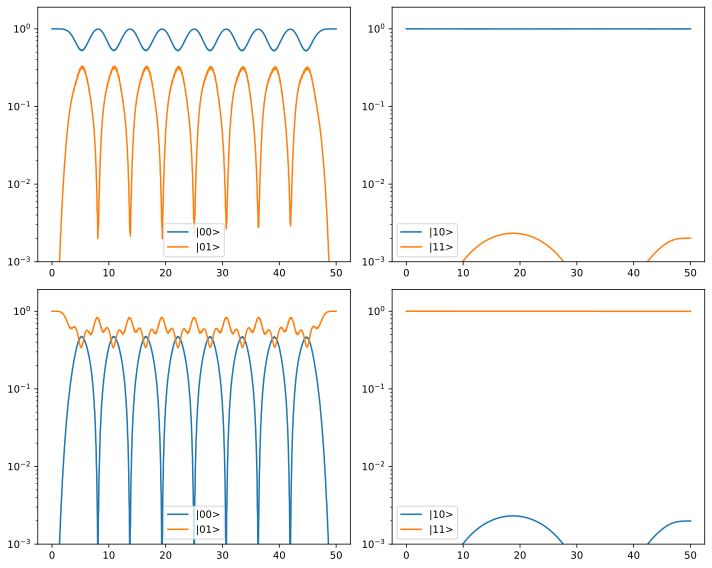

In [2]:
def prob_lists(psi):
    p_lists = [[] for _ in range(4)]
    for ndx in range(len(psi)):
        psi_t = psi[ndx]
        for i in range(4):
            idx1 = i // 2
            idx2 = i % 2
            p_lists[i].append(np.abs(psi_t.overlap(dressed_epairs[idx1, idx2][1]))**2)
    return p_lists

def temp_opt_freq_gen(H_tot, args):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Create 2x2 subplots
    axs = axs.flatten()  # Flatten the 2D array for easier iteration

    initial_states = [
        dressed_epairs[0, 0][1],
        dressed_epairs[1, 0][1],
        dressed_epairs[0, 1][1],
        dressed_epairs[1, 1][1],
    ]

    for i, initial_state in enumerate(initial_states):
        p_lists = prob_lists(qt.sesolve(H_tot, initial_state, t_list, args=args).states)

        # Plot only curves with values above 1e-3
        for j, p_list in enumerate(p_lists):
            if any(p > 1e-3 for p in p_list):
                label = "|" + str(j // 2) + str(j % 2) + ">"
                axs[i].semilogy(t_list, p_list, label=label)

        axs[i].set_ylim(1e-3, 1.9)
        axs[i].legend()
        axs[i].set_facecolor('white')

    plt.tight_layout()
    plt.show()

temp_opt_freq_gen(H_tot, args)

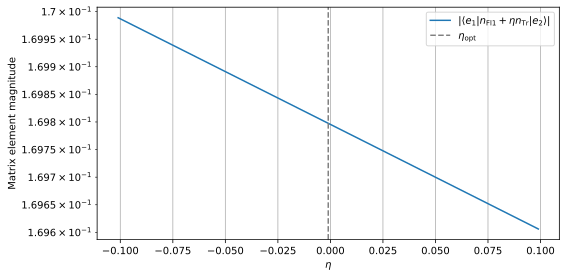

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Sweep eta around opteta
eta_values = np.linspace(opteta - 0.1, opteta + 0.1, 201)

# Target eigenstates from dressed_epairs
e1 = dressed_epairs[0, 0][1]
e2 = dressed_epairs[0, 1][1]

# Compute matrix elements
matrix_elements = [
    (n_F + eta * n_T).matrix_element(e1, e2)
    for eta in eta_values
]

# Convert to magnitude or real/imag parts if desired
magnitudes = np.abs(matrix_elements)
phases = np.angle(matrix_elements)

# Plotting
plt.figure(figsize=(8, 4))
plt.semilogy(eta_values, magnitudes, label=r'$|\langle e_1 | n_{\mathrm{Fl1}} + \eta n_{\mathrm{Tr}} | e_2 \rangle|$')
plt.axvline(opteta, color='gray', linestyle='--', label=r'$\eta_{\mathrm{opt}}$')
plt.xlabel(r'$\eta$')
plt.ylabel('Matrix element magnitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
optalpha, opteta, optdetuning

(np.float64(2.5289324439979537),
 np.float64(-0.001030936261997264),
 np.float64(0.9962870197260766))

In [7]:
print("want high")
print((n_Fl1_full + opteta * n_Tr_full).matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1]))
print((n_Fl1_full + opteta * n_Tr_full).matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1])/(n_Fl1_full + opteta * n_Tr_full).matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
print("unwant low")
print((n_Fl1_full + opteta * n_Tr_full).matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
print((n_Fl1_full + opteta * n_Tr_full).matrix_element(dressed_epairs[0, 1][1], dressed_epairs[0, 2][1]))
print((n_Fl1_full + opteta * n_Tr_full).matrix_element(dressed_epairs[1, 1][1], dressed_epairs[1, 2][1]))
print((n_Fl1_full + opteta * n_Tr_full).matrix_element(dressed_epairs[1, 1][1], dressed_epairs[2, 1][1]))
print((n_Fl1_full + opteta * n_Tr_full).matrix_element(dressed_epairs[1, 0][1], dressed_epairs[2, 0][1]))
print((n_Fl1_full + opteta * n_Tr_full).matrix_element(dressed_epairs[1, 1][1], dressed_epairs[0, 1][1]))

want high
(0.0021894679158467115+5.757488515927614e-18j)
(-0.8965107690521854+7.047632910324095e-15j)
unwant low
(-0.002442210391026841-2.562076400481791e-17j)
(0.0032134169921250763+3.8627993541824743e-17j)
(-0.004151431440995162-1.9768977353230666e-16j)
(3.402186977874815e-17-0.5452597222418358j)
(-3.2014359940692447e-16-0.5452771577511218j)
(2.6258088050340553e-16+0.1698162385882848j)


### Tanvir's parameters

In [3]:
import scqubits as scq
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import scipy.optimize as opt
from qutip.qip.operations import cnot

k = 120
trunc = 6
Fl1 = scq.Fluxonium(EJ=4.1933, EC=1.0617, EL=0.9336, flux=0.5, cutoff=k, truncated_dim=trunc)
Tr = scq.Transmon(EJ=19.98, EC=0.1845, ng=0, ncut=k, truncated_dim=trunc)
"""Fl1 = scq.Fluxonium(EJ=3.95, EC=1.4, EL=0.90, flux=0.5, cutoff=k, truncated_dim=trunc)
Tr = scq.Transmon(EJ=18, EC=0.25, ng=0, ncut=k, truncated_dim=trunc)"""

J1T = 0.022

full_system = scq.HilbertSpace([Fl1, Tr])
full_system.add_interaction(g=J1T, op1=(Fl1.n_operator(), Fl1), op2=(Tr.n_operator(), Tr))
full_system.generate_bare_esys()
full_system.generate_lookup()

H_full = 2 * np.pi * full_system.hamiltonian()
evals, ekets = H_full.eigenstates()

n_Fl1_full = scq.identity_wrap(Fl1.n_operator(), Fl1, [Fl1, Tr])
n_Tr_full = scq.identity_wrap(Tr.n_operator(), Tr, [Fl1, Tr])

# a_Fl1_full = scq.identity_wrap(qt.destroy(trunc), Fl1, [Fl1, Tr])
# a_Tr_full = scq.identity_wrap(qt.destroy(trunc), Tr, [Fl1, Tr])

# adag_Fl1_full = scq.identity_wrap(qt.create(trunc), Fl1, [Fl1, Tr])
# adag_Tr_full = scq.identity_wrap(qt.create(trunc), Tr, [Fl1, Tr])

def get_dressed_epairs(evals, ekets):
    dressed_epairs = np.empty((5, 5), dtype=object)
    for i in range(4):
        for j in range(4):
            index = full_system.dressed_index((i,j))
            ztemp = qt.tensor(qt.basis(6,i),qt.basis(6,j)).overlap(ekets[index])
            np.angle(ztemp)
            dressed_epairs[i,j] = (evals[index], np.exp(-1j*np.angle(ztemp))*ekets[index])
    return dressed_epairs

dressed_epairs = get_dressed_epairs(evals, ekets)

eta = (np.abs(n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]) /
             n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1])))


t_r = 5
t_g = 50

U_id = 0
U_id += dressed_epairs[0, 0][1] * dressed_epairs[0, 0][1].dag()
U_id += dressed_epairs[0, 1][1] * dressed_epairs[0, 1][1].dag()
U_id += dressed_epairs[1, 1][1] * dressed_epairs[1, 0][1].dag()
U_id += dressed_epairs[1, 0][1] * dressed_epairs[1, 1][1].dag()

def U_full2comp(U_f):
    U4x4 = 1j*np.zeros([4,4])
    for dx in range(2):
        for jx in range(2):
            for kx in range(2):
                for lx in range(2):
                    U4x4[2*dx+jx,2*kx+lx] = U_f.matrix_element(dressed_epairs[dx,jx][1],dressed_epairs[kx,lx][1])
    return qt.Qobj(U4x4)

idcomp = qt.Qobj(cnot().full())

def envelop_function(t, tg, t_r):
    if t < t_r:
        fnct = np.sin(np.pi * t / 2 / t_r) ** 2
    elif t < tg - t_r:
        fnct = 1.
    else:
        fnct = np.sin(np.pi * (tg - t) / 2 / t_r) ** 2
    return fnct

'''def time_dep(t, args):
    w_d = args['w_d']
    return 2 * np.cos(w_d * t) * envelop_function(t, args['t_g'], args['t_r'])'''

def gate(H_tot, args):
    comp_space = [dressed_epairs[0, 0][1], dressed_epairs[0, 1][1], dressed_epairs[1, 0][1], dressed_epairs[1, 1][1]]
    U_t = evolution_subspace(H_tot, args, comp_space, t_list)
    U_act = U_t[-1]
    return U_act

def evolution_psi_microwave(H_tot, psi0, t_points, args):
    result = qt.sesolve(H_tot, psi0, t_points, args=args, options=qt.Options(nsteps=25000))
    return result.states

def evolution_subspace(H_tot, args, subspace_states, t_points):
    psi_t = []
    for ind, psi_0 in enumerate(subspace_states):
        temp = evolution_psi_microwave(H_tot, psi_0, t_points=t_points, args=args)
        psi_t.append(temp)

    U_t = np.empty_like(t_points, dtype=object)
    ind_t = len(t_points) - 1
    U = 0
    for ind, psi_0 in enumerate(subspace_states):
        U += psi_t[ind][ind_t] * psi_0.dag()
    U_t[ind_t] = U
    return U_t

def time_dep(t, args):
    w_d = args['w_d']
    return 2 * np.cos(w_d*t) * envelop_function(t,args['t_g'], args['t_r'])

def abs_fidelity_CX1(params, t_g):
    alpha, eta, detuning = params
    w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*detuning
    H_tot = [H_full, [alpha * (n_Fl1_full + eta * n_Tr_full), time_dep]]
    
    args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}
    
    U_act = qt.Qobj(np.abs(U_full2comp(gate(H_tot, args)).full()))

    op1 = U_act.dag() * U_act
    op2 = idcomp.dag() * U_act
    fidelity = (op1.tr() + (abs(op2.tr()))**2) / 20.0
    return -fidelity


t_list = np.linspace(0, t_g, 1000)
initial_guess = [3, eta, 0.9999]
result = opt.minimize(abs_fidelity_CX1, initial_guess, args=(t_g,), method='Nelder-Mead', options={'fatol': 0.00001, 'xatol': 0.00001})
optalpha, opteta, optdetuning = result.x
w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*optdetuning
H_tot = [H_full, [optalpha * (n_Fl1_full + opteta * n_Tr_full), time_dep]]

args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}

U_act = np.abs(U_full2comp(gate(H_tot, args)).full())

max_fidelity = -result.fun

a = 1 - U_act[0,0]
b = 1 - U_act[1,1]
c = 1 - U_act[2,3]
d = 1 - U_act[3,2]

dark = 2*(a + b)/5
flip = 2*(c + d)/5

leak = abs(1 - np.trace(np.transpose(U_act)@U_act)/4)

print(dark, flip, leak, 1 - max_fidelity)
print(result.x)

 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_copy/lib/python3.12/site-packages/qutip/solver/options.py: 16

0.05306422386297309 0.051598860280319105 0.0007260398929971323 0.10138505425239619
[3.61967732e+00 2.41857692e-03 1.00007726e+00]


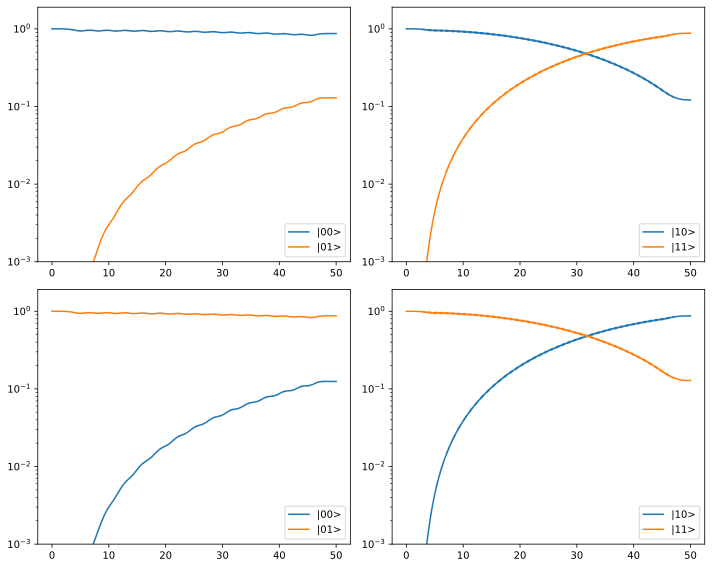

In [4]:
def prob_lists(psi):
    p_lists = [[] for _ in range(4)]
    for ndx in range(len(psi)):
        psi_t = psi[ndx]
        for i in range(4):
            idx1 = i // 2
            idx2 = i % 2
            p_lists[i].append(np.abs(psi_t.overlap(dressed_epairs[idx1, idx2][1]))**2)
    return p_lists

def temp_opt_freq_gen(H_tot, args):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Create 2x2 subplots
    axs = axs.flatten()  # Flatten the 2D array for easier iteration

    initial_states = [
        dressed_epairs[0, 0][1],
        dressed_epairs[1, 0][1],
        dressed_epairs[0, 1][1],
        dressed_epairs[1, 1][1],
    ]

    for i, initial_state in enumerate(initial_states):
        p_lists = prob_lists(qt.sesolve(H_tot, initial_state, t_list, args=args).states)

        # Plot only curves with values above 1e-3
        for j, p_list in enumerate(p_lists):
            if any(p > 1e-3 for p in p_list):
                label = "|" + str(j // 2) + str(j % 2) + ">"
                axs[i].semilogy(t_list, p_list, label=label)

        axs[i].set_ylim(1e-3, 1.9)
        axs[i].legend()
        axs[i].set_facecolor('white')

    plt.tight_layout()
    plt.show()

temp_opt_freq_gen(H_tot, args)

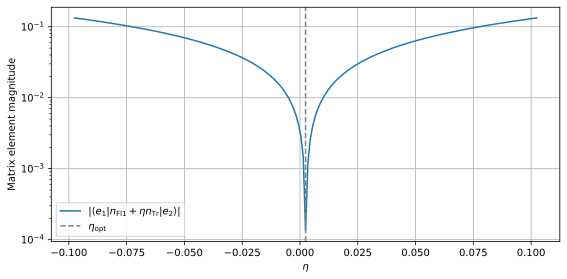

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Sweep eta around opteta
eta_values = np.linspace(opteta - 0.1, opteta + 0.1, 201)

# Target eigenstates from dressed_epairs
e1 = dressed_epairs[0, 0][1]
e2 = dressed_epairs[0, 1][1]

# Compute matrix elements
matrix_elements = [
    (n_Fl1_full + eta * n_Tr_full).matrix_element(e1, e2)
    for eta in eta_values
]

# Convert to magnitude or real/imag parts if desired
magnitudes = np.abs(matrix_elements)
phases = np.angle(matrix_elements)

# Plotting
plt.figure(figsize=(8, 4))
plt.semilogy(eta_values, magnitudes, label=r'$|\langle e_1 | n_{\mathrm{Fl1}} + \eta n_{\mathrm{Tr}} | e_2 \rangle|$')
plt.axvline(opteta, color='gray', linestyle='--', label=r'$\eta_{\mathrm{opt}}$')
plt.xlabel(r'$\eta$')
plt.ylabel('Matrix element magnitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
print("want high")
print((n_Fl1_full + opteta * n_Tr_full).matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1]))
print((n_Fl1_full + opteta * n_Tr_full).matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1])/(n_Fl1_full + opteta * n_Tr_full).matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
print("unwant low")
print((n_Fl1_full + opteta * n_Tr_full).matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
print((n_Fl1_full + opteta * n_Tr_full).matrix_element(dressed_epairs[0, 1][1], dressed_epairs[0, 2][1]))
print((n_Fl1_full + opteta * n_Tr_full).matrix_element(dressed_epairs[1, 1][1], dressed_epairs[1, 2][1]))
print((n_Fl1_full + opteta * n_Tr_full).matrix_element(dressed_epairs[1, 1][1], dressed_epairs[2, 1][1]))
print((n_Fl1_full + opteta * n_Tr_full).matrix_element(dressed_epairs[1, 0][1], dressed_epairs[2, 0][1]))
print((n_Fl1_full + opteta * n_Tr_full).matrix_element(dressed_epairs[1, 1][1], dressed_epairs[0, 1][1]))

want high
(-0.007642096881847787-8.460640927078565e-17j)
(-57.35550768465393-2.655969113783557e-10j)
unwant low
(0.0001332408549823108-6.155250745498719e-16j)
(-0.000319031569126207-7.48056600028238e-19j)
(-0.011737801575361926+1.3301025561130312e-17j)
(-1.469911959191706e-16-0.5714590641792041j)
(3.770829694140118e-16-0.571499033946066j)
(-6.394958537575438e-17+0.13810711889799582j)
